# Read in all traces and store them in a suitable data-structure

Tracer data entails both the time series from the CTD sensors itself as well as the injection meta-data.
The metadata is stored in a CSV-file which you'll need to fill in.

In [70]:
# Load calibration script (also includes helper_functions.jl)
using NBInclude
@nbinclude("2_calibration.ipynb")
# set to false to get interactive plots, false for in-line plots
Makie.inline!(true)

Estimated linear fit: f(delta_cond) = a*conc with
 a = 0.000828±2.31e-5

Estimated linear fit: f(delta_cond) = a*conc with
 a = 0.000829±1.88e-5

Estimated linear fit: f(delta_cond) = a*conc with
 a = 0.000805±1.91e-5

Estimated linear fit: f(delta_cond) = a*conc with
 a = 0.000833±2.01e-5

Estimated linear fit: f(delta_cond) = a*conc with
 a = 0.00814±0.000387

Estimated linear fit: f(delta_cond) = a*conc with
 a = 0.000811±2.12e-5

Estimated linear fit: f(delta_cond) = a*conc with
 a = 0.000471±3.83e-6

Estimated linear fit: f(delta_cond) = a*conc with
 a = 0.000461±6.36e-6

Estimated linear fit: f(delta_cond) = a*conc with
 a = 0.00437±0.000278

Estimated linear fit: f(delta_cond) = a*conc with
 a = 0.000845±9.82e-6

Estimated linear fit: f(delta_cond) = a*conc with
 a = 0.00046±4.97e-6

Estimated linear fit: f(delta_cond) = a*conc with
 a = 0.0082±0.000389



true

Now load data-files from CTD sensors

sens = 145
sens = 309
sens = :wtw


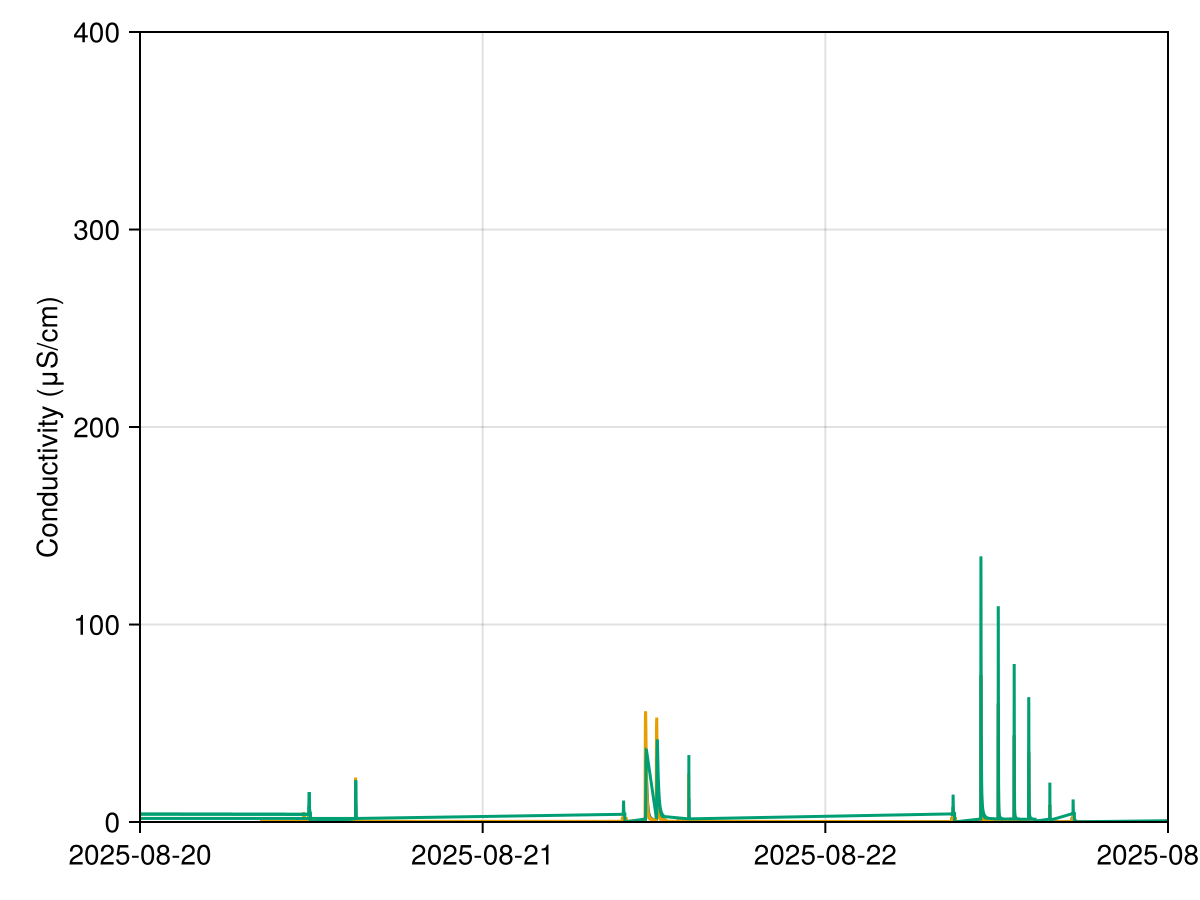

In [87]:
# for each sensor list all data-files
fls = Dict(145=>["../data/raw/Tag1/CTD_unten.csv",
                    "../data/raw/Tag2/CTD_unten.csv",
                    "../data/raw/Tag3/CTD_unten.csv",
                    "../data/raw/Tag4/CTD_unten.csv",],
           309=>["../data/raw/Tag1/CTD_oben.csv",
                    "../data/raw/Tag2/CTD_oben.csv",
                    "../data/raw/Tag3/CTD_oben.csv",
                    "../data/raw/Tag4/CTD_oben.csv",],
           :wtw=> ["../data/raw/Tag1/DATAMEM_WTW/AUTO/AD422473.CSV",
                    "../data/raw/Tag2/WTW/AD508318.CSV",
                    "../data/raw/Tag3/WTW/AD603622.CSV",
                    "../data/raw/Tag4/AD820165.CSV"]
           # :049=>[],
           # :999
           )

# Read sensor time series and concatenate the time series into one for each sensor
sensor_readouts = Dict()
for sens in keys(fls)
    @show sens
    if sens!=:wtw
        local out = read_Keller_DCX22_CTD(fls[sens][1])
        for fl = fls[sens][2:end]
            tmp = read_Keller_DCX22_CTD(fl)
            for (k,v) in tmp
                out[k] = [out[k]; tmp[k]]
            end
        end
        sensor_readouts[sens] = out
        # add calibration function (from 2_calibration.jl)
        sensor_readouts[sens][:cali_fn] = delta_cond2conc[sens]
    else
        local out = read_WTW(fls[sens][1])
        for fl = fls[sens][2:end]
            tmp = read_WTW(fl)
            for (k,v) in tmp
                out[k] = [out[k]; tmp[k]]
            end
        end
        if year(out[:t][1])==2093 # wrong date in the example WTW file
            out[:t] = out[:t] .- (out[:t][1] - DateTime("2021-08-24T08:15:00"))
        end
        sensor_readouts[sens] = out
        # add calibration function (from 2_calibration.jl)
        sensor_readouts[sens][:cali_fn] = delta_cond2conc[sens]
    end
end

# Plot concatenated conductivity time-series for all sensors
fig = Figure()
ax = Axis(fig[1,1], ylabel="Conductivity (μS/cm)")
for sens in keys(sensor_readouts)
    lines!(ax, sensor_readouts[sens][:t], sensor_readouts[sens][:cond],
            label = sens)
end
ylims!(ax, 0, 400)  # set y-axis limit
xlims!(ax, Date("2025-08-20"), Date("2025-08-23"))  # set x-axis range

fig

Read tracer metadata.  This CSV-file needs to have the format

`Experiment No,Location,Date, Injection time, End time, Salt mass [g], 145, 049, 309`

(add more sensors to the back if needed, or remove some if not needed)

In [67]:
metafile = "../data/raw/tracer_metadata.csv"
d,h = readdlm(metafile, ',', header=true)
h = [hh isa AbstractString ? strip(hh) : hh for hh in h] # remove white-space for strings
d = [dd isa AbstractString ? strip(dd) : dd for dd in d] # remove white-space for strings
sensor_names = [tryparse(Int, hh)===nothing ? Symbol(hh) : parse(Int, hh) for hh in h[7:end]]

3-element Vector{Any}:
 145
 309
    :wtw

# Make the individual traces

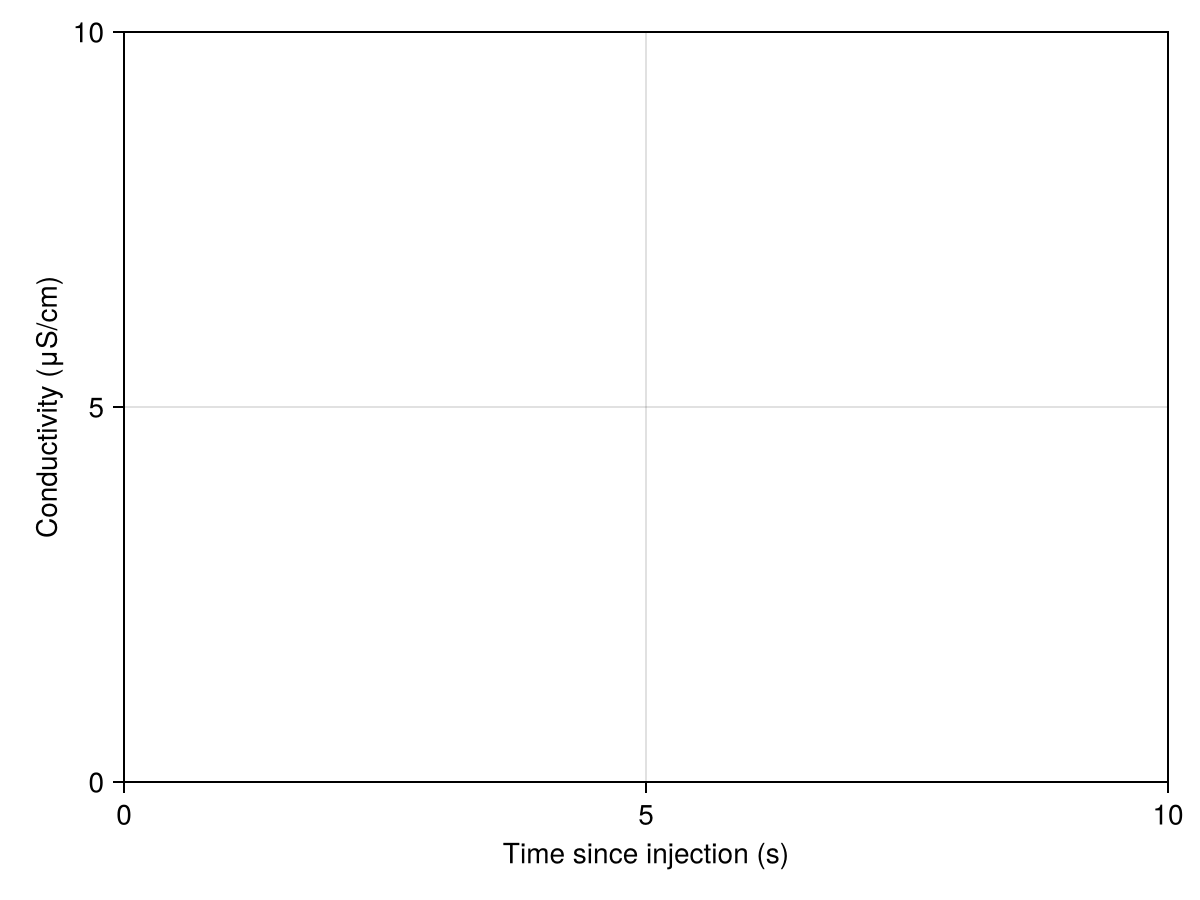

In [86]:
"""
A data-structure to hold data from one trace
"""
struct Trace
    nr # id number of trace
    location # where on the glacier
    mass # injected salt mass [g]
    tinj # injection as DateTime object
    tend # end of trace (probably when back to background or when recording stopped)
    sensors # record of each sensor
    products # this is where all the further processed stuff goes
end

# Go through all meta-data lines (from the CSV-file) and creates a Tracer-experiment for it
traces = []
for nr in 1:size(d,1)
    # parse times:
    tinj = Dates.Date(d[nr,3], DateFormat("dd.mm.yyyy")) + Dates.Time(d[nr,4], "HH:MM")
    tend = Dates.Date(d[nr,3], DateFormat("dd.mm.yyyy")) + Dates.Time(d[nr,5], "HH:MM")

    # figure out which sensors/loggers were used
    sensors = Dict()
    for snr in 1:length(sensor_names)
        local sens = sensor_names[snr]
        if !haskey(sensor_readouts, sens)
            @warn("No data for sensor $sens")
            continue
        end
        if d[nr, snr+6]!="x"
            loc = d[nr, snr+6]
            sensors[loc] = cut_sensor_readout(sensor_readouts[sens], tinj, tend)
            sensors[loc][:sensor_name] = sens
        end
    end

    # create an instance of the Trace-struct and push it to the list holding all traces
    push!(traces,
          Trace(nr,
           d[nr,2],
           Float64(d[nr,6]),
           tinj,
           tend,
           sensors,
           Dict()
           ))
end

"""
    plot_trace(tr, field=:cond)

Function to plot a tracer experiment, possibly consisting of
several detectors.
"""
function plot_trace(tr, field=:cond)
    f = Figure(); Axis(f[1,1],
            xlabel="Time since injection (s)",
            ylabel=field==:cond ? "Conductivity (μS/cm)" : "")
    for (k,sens) in tr.sensors
        lines!(sens[:tsec], sens[field])
    end
    # if isempty(tr.products)
    #     legend([v[:sensor_name] for (k,v) in tr.sensors])
    # else
    #     legend(["$(v[:sensor_name]), loc=$k, Q=$(round(tr.products[k][:Q], sigdigits=2)) m³/s" for (k,v) in tr.sensors])
    # end
    return f
end

# Example
f = plot_trace(traces[2])

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*